In [1]:
# notebook magics
# inline/notebook/interactive
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# import utilities and plotting
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
# make figures higher resolution (larger)
plt.rcParams['figure.dpi'] = 150
# A decent backend for animations
plt.rcParams["animation.html"] = "jshtml"
# let 'em get big
plt.rcParams["animation.embed_limit"] = 100  # MB

# import our code that we need
import os, sys 
sys.path.append(os.path.abspath("lib")) # N.B: NB needs this line to run locally!!

import linalg_helper as lib
from plotting import plotpotential2D, plotpsi2D
import fixed_center_of_mass_exact as fcm
#import fixed_center_of_mass_exact as fsm
from davidson import get_davidson_mem
from debug import timer_ctx
from constants import *

# don't use too many cores
from threadpoolctl import ThreadpoolController
threadctl = ThreadpoolController()
threadctl.limit(limits=16)

In [103]:
# set up the calculation
args = Namespace(
    M_1 = 10000, M_2 = 10000,
    g_1 = 1.0, g_2 = 1.0,
    #NR = 6, #6, 30
    #Nr = 50,
    #Ng = 40, # 80
    NR = 201,
    Nr = 42,
    Ng = 34,
    J = 0,
    extent = np.array((1/51, .7, .7)),
    funcparams=dict(dv=0.5, G=36, p=1),
    preconditioner='BO', t=16,
    #extent = (0.94,1.89,10.6)   # defaults are (2,4,5), but they should be selected better (R_min, R_max, r_max)
)

# build the terms in the Hamiltonian
H = fcm.Hamiltonian(args)

levels = np.linspace(np.min(H.Vgrid), np.min(H.Vgrid) + 0.15*4, 16) # 0.15 a.u. ~4 eV range
print(levels)

{'dv': 0.5, 'G': 36, 'p': 1}
unscaled coords: [0.01960784 0.7       ] 0.7
  scaled coords: [0.00440637 0.15730733] 11.123585707855012
Mock call to tqdm({'total': 201, 'desc': 'Building U_n'})
Mock call to tqdm({'total': 1428, 'desc': 'Building U_v'})
[Build preconditioner BO] Elapsed time: 1.99e+07us
[-77.80380975 -77.76380975 -77.72380975 -77.68380975 -77.64380975
 -77.60380975 -77.56380975 -77.52380975 -77.48380975 -77.44380975
 -77.40380975 -77.36380975 -77.32380975 -77.28380975 -77.24380975
 -77.20380975]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.03971324237771512 0.26586400970764146 0.14937427003145692


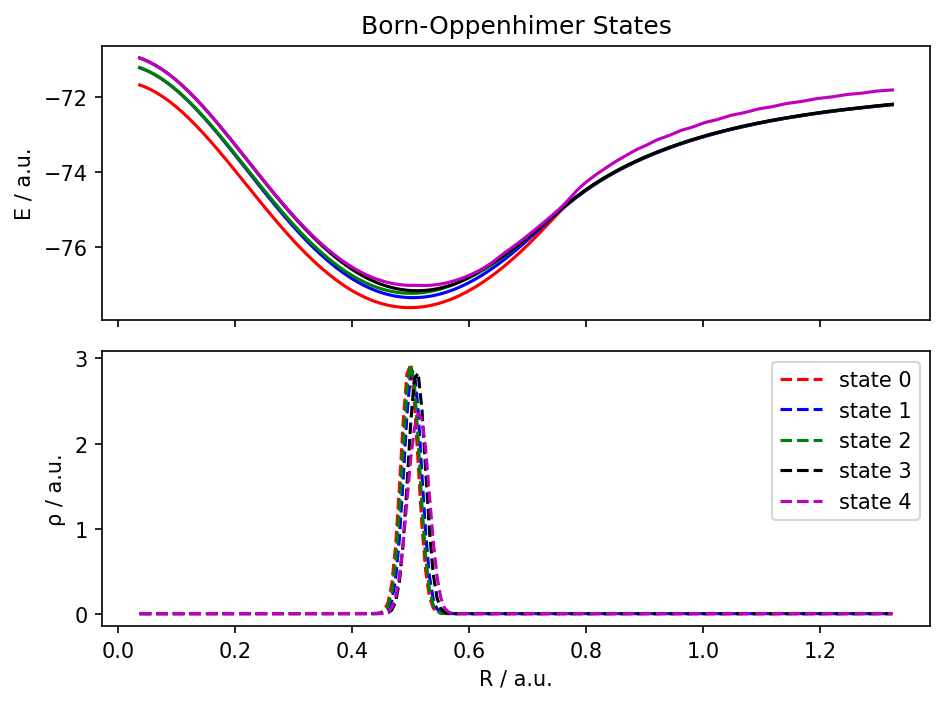

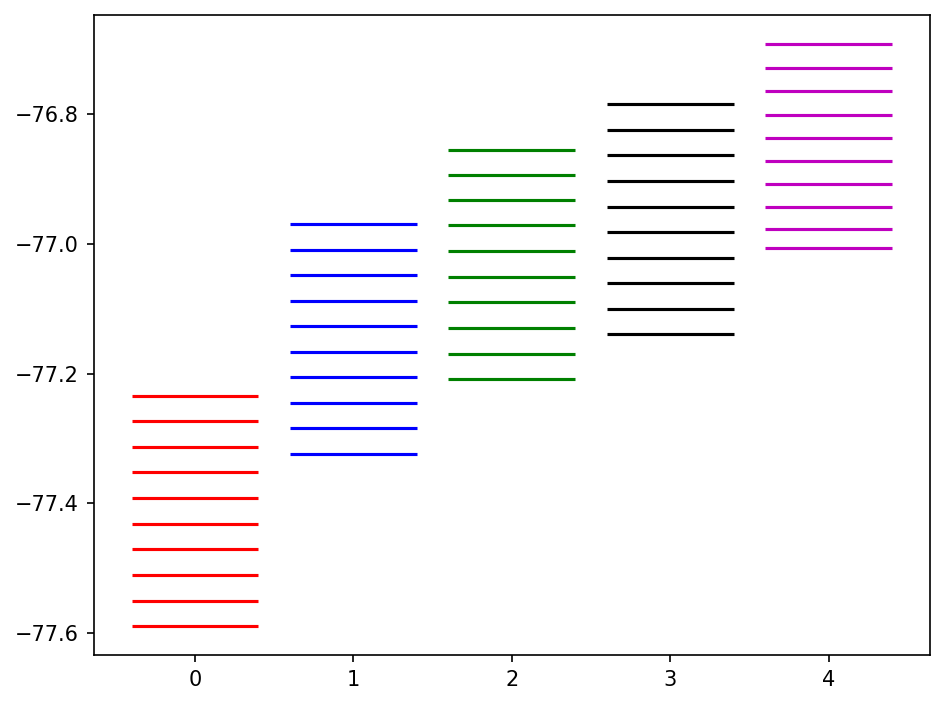

In [104]:
Ad_vn, U_n, U_v, BO_surf = H._preconditioner_data

fig, (ax, axpsi) = plt.subplots(nrows=2, sharex=True)
colors=['r','b','g','k','m']
for i in range(5):
    ax.plot(H.R_lab, BO_surf[:,i], color=colors[i])
    psi_bo = U_v[i,:,0]/np.sqrt(H.R)
    psi_bo2 = psi_bo**2
    axpsi.plot(H.R_lab, psi_bo2, '--', color=colors[i], label=f'state {i}')
axpsi.legend(loc='best')
axpsi.set_xlabel("R / a.u.")
ax.set_ylabel("E / a.u.")
axpsi.set_ylabel("ρ / a.u.")
#plt.ylim(-0.018,-0.007)
#ax.set_xlim(0,1)
#ax.plot(H.R_lab, H.Vgrid[:,0,0])
#ax.set_ylim(top=0)
ax.set_title("Born-Oppenhimer States")
fig.tight_layout()




figv, axv = plt.subplots()
for n in range(5):
    axv.hlines(Ad_vn[:10,n], (n-0.4), (n+0.4), color=colors[n])
figv.tight_layout()

vib_gap = Ad_vn[1,0] - Ad_vn[0,0]
ele_gap = Ad_vn[0,1] - Ad_vn[0,0]
print(vib_gap, ele_gap, vib_gap/ele_gap)

display(fig)
display(figv)

In [88]:
#display(plotpotential2D(H, levels))

In [ ]:
# Build BO surfaces
BO, BO_surf = H.BO_spectrum()
BO_colors=['r','b','g','k','m']

In [ ]:
# Plot vibrational progression
fig, ax = plt.subplots()
for n in range(5):
    ax.hlines(BO[:10,n] - BO[0,0], (n-0.4), (n+0.4), color=BO_colors[n])
    #ax.hlines(BO[n,:10] - BO[0,0], (n-0.4), (n+0.4), color=BO_colors[n])
    #plt.hlines(BOorig[:10,n] - BOorig[0,0], (n-0.4), (n+0.4), 'k')
display(fig)

In [ ]:
fig, ax = plt.subplots()
colors=['r','b','g','k','m']
for i in range(5):
    ax.plot(H.R_lab, BO_surf[:,i], color=BO_colors[i%len(BO_colors)])

ax.set_xlabel("R / a.u.")
ax.set_ylabel("E / a.u.")
#plt.ylim(-0.06,0.03)
ax.set_title("Born-Oppenhimer Surfaces")
display(fig)
print("R_minimum =", H.R[np.argmin(BO_surf[:,0])], np.min(BO_surf[:,0]))

In [ ]:
# BO preconditioner
#args.preconditioner = 'BO'
#H = fcm.Hamiltonian(args)


In [ ]:
Ad_vn, U_n, U_v = H._preconditioner_data

fig, (ax, axpsi) = plt.subplots(nrows=2)
colors=['r','b','g','k','m']
for i in range(5):
    ax.plot(H.R_lab, BO_surf[:,i], color=colors[i])
    psi_bo = U_v[i,:,0]/np.sqrt(H.R)
    psi_bo2 = psi_bo**2
    axpsi.plot(H.R_lab, psi_bo2, '--', color=colors[i], label=f'state {i}')
axpsi.legend(loc='best')
ax.set_xlabel("R / a.u.")
ax.set_ylabel("E / a.u.")
#plt.ylim(-0.018,-0.007)
#ax.set_xlim(0,1)
ax.set_title("Born-Oppenhimer States")

display(fig)

In [ ]:
# BO states are like: U_n[:,:,n]
# vib states are like: U_v[n,:,v]
# our first guess is the ground state BO wavefuction dressed by the first vibrational state
#Ad_vn, U_n, U_v = H._preconditioner_data
#v = 0
#n = 0
#guess = U_n[:,:,n] * U_v[n,:,v,np.newaxis]
#guess = guess.reshape(H.shape)

guess = H.make_guess(5)
display(plotpsi2D(guess[0], H, levels[-2:]))

In [ ]:
# BO states are like: U_n[:,:,n]
# vib states are like: U_v[n,:,v]
# our first guess is the ground state BO wavefuction dressed by the first vibrational state
Ad_vn, U_n, U_v = H._preconditioner_data

display(plotpsi2D(U_n[:,:,0], H, levels[-2:]))

In [ ]:
# actually solve the system
with timer_ctx(f"Davidson of size {np.prod(H.shape)}"):
    conv, e_approx, evecs = lib.davidson1(
        lambda xs: [ H @ x for x in xs ],
        guess,
        H.preconditioner,
        nroots=5,
        max_cycle=100,
        verbose=5,
        max_space=1000,
        max_memory=get_davidson_mem(0.75),
        tol=1e-12,
    )

In [ ]:
display(plotpsi2D(evecs[1], H))

In [ ]:
display(plotpsi2D(evecs[0], H))

In [ ]:
npz = np.load("../2D_101_400_158_new.npz", allow_pickle=True)
evs = npz['guess']
Hnew = npz['H'].item()

display(plotpsi2D(evs[0].reshape(Hnew.shape), Hnew))